# Notebook 03: Feature Engineering

**Objetivo**: Crear features temporales, de rezago y estadísticas para modelado predictivo de urgencias.

## Estrategia:
1. Cargar datos de urgencias redefinidas (Definición A: Percentil 75)
2. Filtrar productos con predictibilidad Moderada/Alta
3. Crear features:
   - **Temporales**: semana, mes, trimestre, estacionalidad
   - **Lags**: rezagos de ventas (1, 2, 4, 8, 52 semanas)
   - **Rolling stats**: MA, std, min, max en ventanas móviles
   - **Urgency-specific**: días desde última urgencia, frecuencia
4. Preparar train/test split temporal
5. Guardar dataset listo para modelado

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Librerías cargadas")

✓ Librerías cargadas


## 1. Carga de Datos

In [16]:
# Cargar urgencias redefinidas
df_urgencias = pd.read_csv('../data/simulated/urgencias_redefinidas.csv')
df_urgencias['week_start'] = pd.to_datetime(df_urgencias['week_start'])

# Cargar clasificación de productos
df_productos = pd.read_csv('../data/simulated/productos_predecibles.csv')

print(f"Datos cargados:")
print(f"  • Registros totales: {len(df_urgencias):,}")
print(f"  • Productos únicos: {df_urgencias['item_id'].nunique():,}")
print(f"  • Rango temporal: {df_urgencias['week_start'].min()} a {df_urgencias['week_start'].max()}")
print(f"\nDistribución de predictibilidad:")
print(df_productos['clasificacion'].value_counts())

Datos cargados:
  • Registros totales: 847,622
  • Productos únicos: 3,049
  • Rango temporal: 2011-01-29 00:00:00 a 2016-05-21 00:00:00

Distribución de predictibilidad:
clasificacion
Moderado      2412
Errático       593
Predecible      44
Name: count, dtype: int64


In [17]:
# Filtrar solo productos Predecibles y Moderados
productos_modelar = df_productos[
    df_productos['clasificacion'].isin(['Predecible', 'Moderado'])
]['item_id'].unique()

df = df_urgencias[df_urgencias['item_id'].isin(productos_modelar)].copy()
df = df.sort_values(['item_id', 'week_start']).reset_index(drop=True)

print(f"\n✓ Dataset filtrado:")
print(f"  • Productos a modelar: {len(productos_modelar):,}")
print(f"  • Registros: {len(df):,}")
print(f"  • Proporción urgencias: {df['is_urgent_a'].mean():.1%}")


✓ Dataset filtrado:
  • Productos a modelar: 2,456
  • Registros: 682,768
  • Proporción urgencias: 24.4%


## 2. Features Temporales

In [18]:
# Extraer componentes temporales
df['year'] = df['week_start'].dt.year
df['month'] = df['week_start'].dt.month
df['quarter'] = df['week_start'].dt.quarter
df['week_of_year'] = df['week_start'].dt.isocalendar().week
df['day_of_year'] = df['week_start'].dt.dayofyear

# Features cíclicas (sin/cos para capturar periodicidad)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)

# Indicadores especiales
df['is_q4'] = (df['quarter'] == 4).astype(int)  # Q4 suele tener alta demanda
df['is_january'] = (df['month'] == 1).astype(int)  # Enero post-navidad

print("✓ Features temporales creadas")
print(f"  • Columnas temporales: {['year', 'month', 'quarter', 'week_of_year', 'month_sin', 'month_cos', 'week_sin', 'week_cos']}")

✓ Features temporales creadas
  • Columnas temporales: ['year', 'month', 'quarter', 'week_of_year', 'month_sin', 'month_cos', 'week_sin', 'week_cos']


## 3. Lag Features (Rezagos)

In [19]:
# Crear lags de ventas por producto
lag_periods = [1, 2, 4, 8, 52]  # 1w, 2w, 1m, 2m, 1y

for lag in lag_periods:
    df[f'sales_lag_{lag}'] = df.groupby('item_id')['total_sales'].shift(lag)
    print(f"  • Lag {lag} semanas creado")

# Lags de urgencias (binario)
for lag in [1, 2, 4]:
    df[f'urgent_lag_{lag}'] = df.groupby('item_id')['is_urgent_a'].shift(lag)

print("\n✓ Lag features creadas")

  • Lag 1 semanas creado
  • Lag 2 semanas creado
  • Lag 4 semanas creado
  • Lag 8 semanas creado
  • Lag 52 semanas creado

✓ Lag features creadas


## 4. Rolling Statistics (Ventanas Móviles)

In [20]:
# Media móvil y estadísticas en ventanas de 4, 8, 12 semanas
# Nota: ma_4 ya existe del notebook 02, por lo que creamos nuevas columnas con prefijo 'roll_'
windows = [4, 8, 12]

for window in windows:
    # Media móvil
    df[f'roll_ma_{window}'] = df.groupby('item_id')['total_sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    
    # Desviación estándar móvil
    df[f'roll_std_{window}'] = df.groupby('item_id')['total_sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std()
    )
    
    # Mínimo y máximo móvil
    df[f'roll_min_{window}'] = df.groupby('item_id')['total_sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).min()
    )
    
    df[f'roll_max_{window}'] = df.groupby('item_id')['total_sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).max()
    )
    
    print(f"  • Rolling stats ventana {window} semanas")

# Features derivadas - usar la ma_4 existente del notebook 02
df['sales_vs_ma4'] = df['total_sales'] / (df['ma_4'] + 1)  # Ratio vs tendencia
df['sales_vs_roll_ma12'] = df['total_sales'] / (df['roll_ma_12'] + 1)

print("\n✓ Rolling statistics creadas")

  • Rolling stats ventana 4 semanas
  • Rolling stats ventana 8 semanas
  • Rolling stats ventana 12 semanas

✓ Rolling statistics creadas


## 5. Features Específicas de Urgencias

In [21]:
def calcular_dias_desde_ultima_urgencia(grupo):
    """Calcula días desde la última urgencia para cada producto"""
    dias = []
    ultimo_urgente = None
    
    for idx, row in grupo.iterrows():
        if ultimo_urgente is None:
            dias.append(0)
        else:
            dias.append((row['week_start'] - ultimo_urgente).days)
        
        if row['is_urgent_a'] == 1:
            ultimo_urgente = row['week_start']
    
    return pd.Series(dias, index=grupo.index)

# Días desde última urgencia
df['days_since_urgent'] = df.groupby('item_id').apply(calcular_dias_desde_ultima_urgencia).values

# Frecuencia de urgencias en ventanas móviles
for window in [4, 8, 12]:
    df[f'urgent_freq_{window}w'] = df.groupby('item_id')['is_urgent_a'].transform(
        lambda x: x.rolling(window=window, min_periods=1).sum()
    )
    
    df[f'urgent_rate_{window}w'] = df[f'urgent_freq_{window}w'] / window

print("✓ Features de urgencias creadas")
print(f"  • days_since_urgent: promedio {df['days_since_urgent'].mean():.1f} días")
print(f"  • urgent_rate_4w: promedio {df['urgent_rate_4w'].mean():.2%}")

✓ Features de urgencias creadas
  • days_since_urgent: promedio 64.8 días
  • urgent_rate_4w: promedio 24.25%


## 6. Features de Tendencia

In [22]:
# Diferencias (cambio respecto a semana anterior)
df['sales_diff_1'] = df.groupby('item_id')['total_sales'].diff(1)
df['sales_diff_4'] = df.groupby('item_id')['total_sales'].diff(4)

# Tasa de crecimiento
df['sales_pct_change_1'] = df.groupby('item_id')['total_sales'].pct_change(1)
df['sales_pct_change_4'] = df.groupby('item_id')['total_sales'].pct_change(4)

# Momentum (diferencia entre MA corta y larga) - usar roll_ma ya que ma_4 viene del notebook 02
df['momentum'] = df['roll_ma_4'] - df['roll_ma_12']

print("✓ Features de tendencia creadas")

✓ Features de tendencia creadas


## 7. Limpieza y Preparación Final

In [23]:
# Revisar valores faltantes
print("Missing values por columna:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing.head(10))

# Rellenar missing values
# Para lags: forward fill (usamos el valor anterior)
lag_cols = [col for col in df.columns if 'lag_' in col or 'roll_std_' in col]
df[lag_cols] = df.groupby('item_id')[lag_cols].ffill()

# Para diferencias y pct_change: rellenar con 0
diff_cols = [col for col in df.columns if 'diff' in col or 'pct_change' in col]
df[diff_cols] = df[diff_cols].fillna(0)

# Reemplazar infinitos por NaN y luego rellenar
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

print(f"\n✓ Missing values manejados")
print(f"  • Nulls restantes: {df.isnull().sum().sum()}")

Missing values por columna:
sales_pct_change_1    163821
sales_pct_change_4    162858
sales_lag_52          127712
sales_lag_8            19648
urgent_lag_4            9824
sales_diff_4            9824
sales_lag_4             9824
sales_lag_2             4912
urgent_lag_2            4912
urgent_lag_1            2456
dtype: int64

✓ Missing values manejados
  • Nulls restantes: 0


## 8. Análisis de Correlaciones

In [24]:
# Seleccionar features numéricas relevantes
feature_cols = [col for col in df.columns if col not in [
    'item_id', 'week_start', 'week_id', 'week_num', 'total_sales', 
    'is_urgent_a', 'is_urgent_b', 'is_urgent_c',
    'threshold_a', 'threshold_b', 'threshold_c', 'mean_prod', 'std_prod',
    'category', 'dept'
]]

# Calcular correlación con variable objetivo
correlations = df[feature_cols + ['is_urgent_a']].corr()['is_urgent_a'].drop('is_urgent_a')
correlations = correlations.sort_values(ascending=False)

print("\n📊 TOP 15 FEATURES MÁS CORRELACIONADAS CON URGENCIA:")
print(correlations.head(15))

print("\n📊 BOTTOM 10 FEATURES (menor correlación):")
print(correlations.tail(10))


📊 TOP 15 FEATURES MÁS CORRELACIONADAS CON URGENCIA:
urgent_freq_4w        0.786577
urgent_rate_4w        0.786577
urgent_rate_8w        0.708868
urgent_freq_8w        0.708868
urgent_freq_12w       0.657122
urgent_rate_12w       0.657122
urgent_lag_1          0.560396
urgent_lag_2          0.489545
urgent_lag_4          0.480066
sales_vs_ma4          0.393563
sales_vs_roll_ma12    0.319963
roll_max_4            0.164819
ma_4                  0.163818
roll_ma_4             0.163818
sales_lag_1           0.161451
Name: is_urgent_a, dtype: float64

📊 BOTTOM 10 FEATURES (menor correlación):
is_january          -0.004079
week_cos            -0.006276
month_cos           -0.010626
quarter             -0.019478
week_of_year        -0.019954
is_q4               -0.020390
mes                 -0.020404
month               -0.020404
day_of_year         -0.024052
days_since_urgent   -0.192091
Name: is_urgent_a, dtype: float64


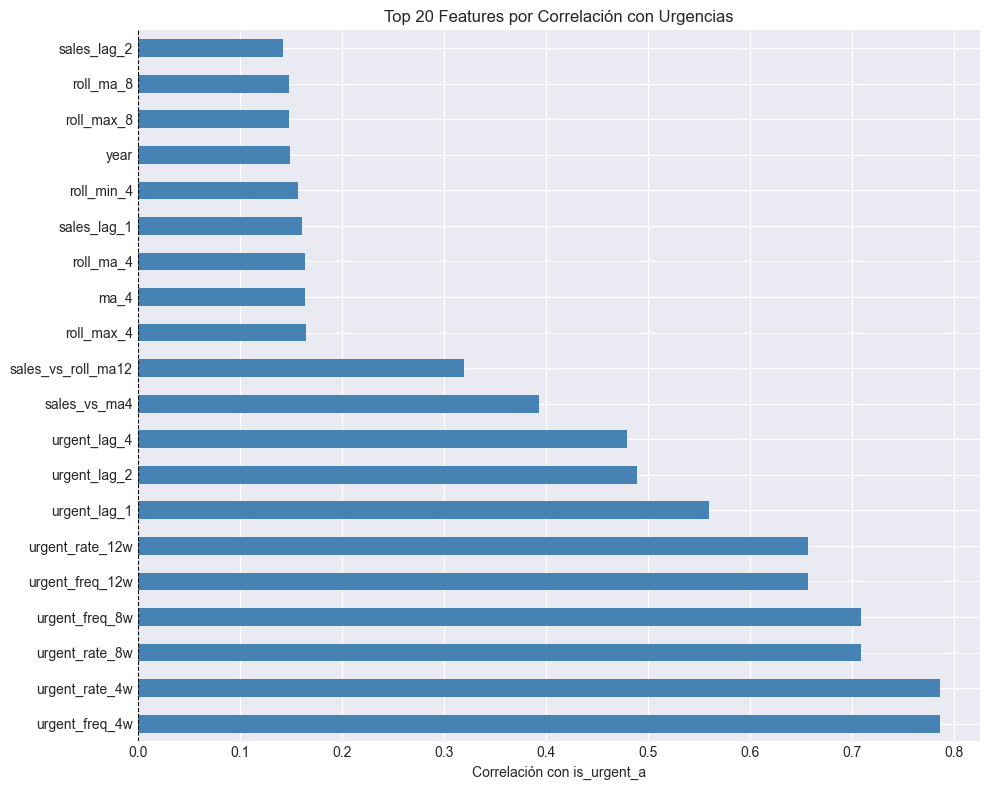

✓ Gráfico guardado: results/feature_correlations.png


In [25]:
# Visualizar top correlaciones
fig, ax = plt.subplots(figsize=(10, 8))
top_corr = correlations.head(20)
top_corr.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Correlación con is_urgent_a')
ax.set_title('Top 20 Features por Correlación con Urgencias')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.savefig('../results/feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: results/feature_correlations.png")

## 9. Train/Test Split Temporal

In [26]:
# Split temporal: últimas 26 semanas (6 meses) para test
fechas_unicas = sorted(df['week_start'].unique())
fecha_split = fechas_unicas[-26]  # Últimas 26 semanas para test

df_train = df[df['week_start'] < fecha_split].copy()
df_test = df[df['week_start'] >= fecha_split].copy()

print(f"\n📅 SPLIT TEMPORAL:")
print(f"\nTRAIN:")
print(f"  • Fechas: {df_train['week_start'].min()} a {df_train['week_start'].max()}")
print(f"  • Semanas: {df_train['week_start'].nunique()}")
print(f"  • Registros: {len(df_train):,}")
print(f"  • Urgencias: {df_train['is_urgent_a'].sum():,} ({df_train['is_urgent_a'].mean():.1%})")

print(f"\nTEST:")
print(f"  • Fechas: {df_test['week_start'].min()} a {df_test['week_start'].max()}")
print(f"  • Semanas: {df_test['week_start'].nunique()}")
print(f"  • Registros: {len(df_test):,}")
print(f"  • Urgencias: {df_test['is_urgent_a'].sum():,} ({df_test['is_urgent_a'].mean():.1%})")


📅 SPLIT TEMPORAL:

TRAIN:
  • Fechas: 2011-01-29 00:00:00 a 2015-11-21 00:00:00
  • Semanas: 252
  • Registros: 618,912
  • Urgencias: 141,502 (22.9%)

TEST:
  • Fechas: 2015-11-28 00:00:00 a 2016-05-21 00:00:00
  • Semanas: 26
  • Registros: 63,856
  • Urgencias: 25,062 (39.2%)


## 10. Guardar Datasets Preparados

In [27]:
# Guardar dataset completo con features
df.to_csv('../data/simulated/dataset_features.csv', index=False)
print(f"✓ Dataset completo guardado: data/simulated/dataset_features.csv")
print(f"  • Shape: {df.shape}")

# Guardar train/test
df_train.to_csv('../data/simulated/train_features.csv', index=False)
df_test.to_csv('../data/simulated/test_features.csv', index=False)
print(f"\n✓ Train/Test guardados:")
print(f"  • train_features.csv: {df_train.shape}")
print(f"  • test_features.csv: {df_test.shape}")

# Guardar lista de features para modelado
features_modeling = [col for col in feature_cols if col in df.columns]
pd.DataFrame({'feature': features_modeling}).to_csv('../data/simulated/feature_list.csv', index=False)
print(f"\n✓ Lista de features guardada: {len(features_modeling)} features")

✓ Dataset completo guardado: data/simulated/dataset_features.csv
  • Shape: (682768, 62)

✓ Train/Test guardados:
  • train_features.csv: (618912, 62)
  • test_features.csv: (63856, 62)

✓ Lista de features guardada: 47 features


## 11. Resumen Final

In [28]:
print("\n" + "="*70)
print("📊 RESUMEN FEATURE ENGINEERING")
print("="*70)

print(f"\n✓ Productos procesados: {df['item_id'].nunique():,}")
print(f"✓ Registros totales: {len(df):,}")
print(f"✓ Features creadas: {len(feature_cols)}")

print(f"\n📂 ARCHIVOS GENERADOS:")
print(f"  • dataset_features.csv - Dataset completo con todas las features")
print(f"  • train_features.csv - Training set ({len(df_train):,} registros)")
print(f"  • test_features.csv - Test set ({len(df_test):,} registros)")
print(f"  • feature_list.csv - Lista de features para modelado")
print(f"  • feature_correlations.png - Visualización de correlaciones")

print(f"\n🎯 CARACTERÍSTICAS DEL DATASET:")
print(f"  • Target: is_urgent_a (Definición A: Percentil 75)")
print(f"  • Balance: {df['is_urgent_a'].mean():.1%} urgencias")
print(f"  • Horizonte temporal: {df['week_start'].nunique()} semanas")
print(f"  • Split: {len(df_train)} train / {len(df_test)} test")

print(f"\n✅ DATASET LISTO PARA MODELADO")
print(f"\nPróximos pasos:")
print(f"  → Fase 4: Modelado con Prophet")
print(f"  → Fase 5: Modelado con XGBoost")
print(f"  → Fase 6: Modelado con Random Forest")
print(f"  → Fase 7: Comparación de modelos")
print("="*70)


📊 RESUMEN FEATURE ENGINEERING

✓ Productos procesados: 2,456
✓ Registros totales: 682,768
✓ Features creadas: 47

📂 ARCHIVOS GENERADOS:
  • dataset_features.csv - Dataset completo con todas las features
  • train_features.csv - Training set (618,912 registros)
  • test_features.csv - Test set (63,856 registros)
  • feature_list.csv - Lista de features para modelado
  • feature_correlations.png - Visualización de correlaciones

🎯 CARACTERÍSTICAS DEL DATASET:
  • Target: is_urgent_a (Definición A: Percentil 75)
  • Balance: 24.4% urgencias
  • Horizonte temporal: 278 semanas
  • Split: 618912 train / 63856 test

✅ DATASET LISTO PARA MODELADO

Próximos pasos:
  → Fase 4: Modelado con Prophet
  → Fase 5: Modelado con XGBoost
  → Fase 6: Modelado con Random Forest
  → Fase 7: Comparación de modelos
